Phonetik Daten
==============
Load Data and take a peek.

In [1]:
library(dplyr)
library(ggplot2)
library(elasticproc2d)
library(grid)
library(gridExtra)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
# From '..phonetik/code/Rfiles/readdata.R'
pouplier <- read.csv(file = "../data/phonetik_consulting/Daten/UltrasoundData_Frame3_AllSpeakers.txt", sep = "\t", header = TRUE)
pouplier$COMPL <- pouplier$RHO * exp(1.i*pouplier$THETA)
pouplier$X1 <- Re(pouplier$COMPL)
pouplier$X2 <- Im(pouplier$COMPL)

In [3]:
head(pouplier)

,VPN,REP,FRAME,WORD,VCODE,CCODE,THETA,RHO,COMPL,X1,X2
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<cpl>,<dbl>,<dbl>
1,D1,1,3,pada,aa,d,1.037,57.0108,29.00739+49.07955i,29.00739,49.07955
2,D1,1,3,pada,aa,d,1.088,56.9207,26.42587+50.41467i,26.42587,50.41467
3,D1,1,3,pada,aa,d,1.138,56.2112,23.57559+51.02833i,23.57559,51.02833
4,D1,1,3,pada,aa,d,1.189,54.8924,20.45225+50.93997i,20.45225,50.93997
5,D1,1,3,pada,aa,d,1.239,53.9110,17.56107+50.97063i,17.56107,50.97063
6,D1,1,3,pada,aa,d,1.290,53.1188,14.72033+51.03841i,14.72033,51.03841


## "pada" and "pidi" total means

In [4]:
pada <- pouplier %>%
    filter(WORD == "pada") %>%
    select(VPN, REP, X1, X2) %>%
    group_by(VPN, REP) %>%
    group_split(.keep = FALSE)

pidi <- pouplier %>%
    filter(WORD == "pidi") %>%
    select(VPN, REP, X1, X2) %>%
    group_by(VPN, REP) %>%
    group_split(.keep = FALSE)

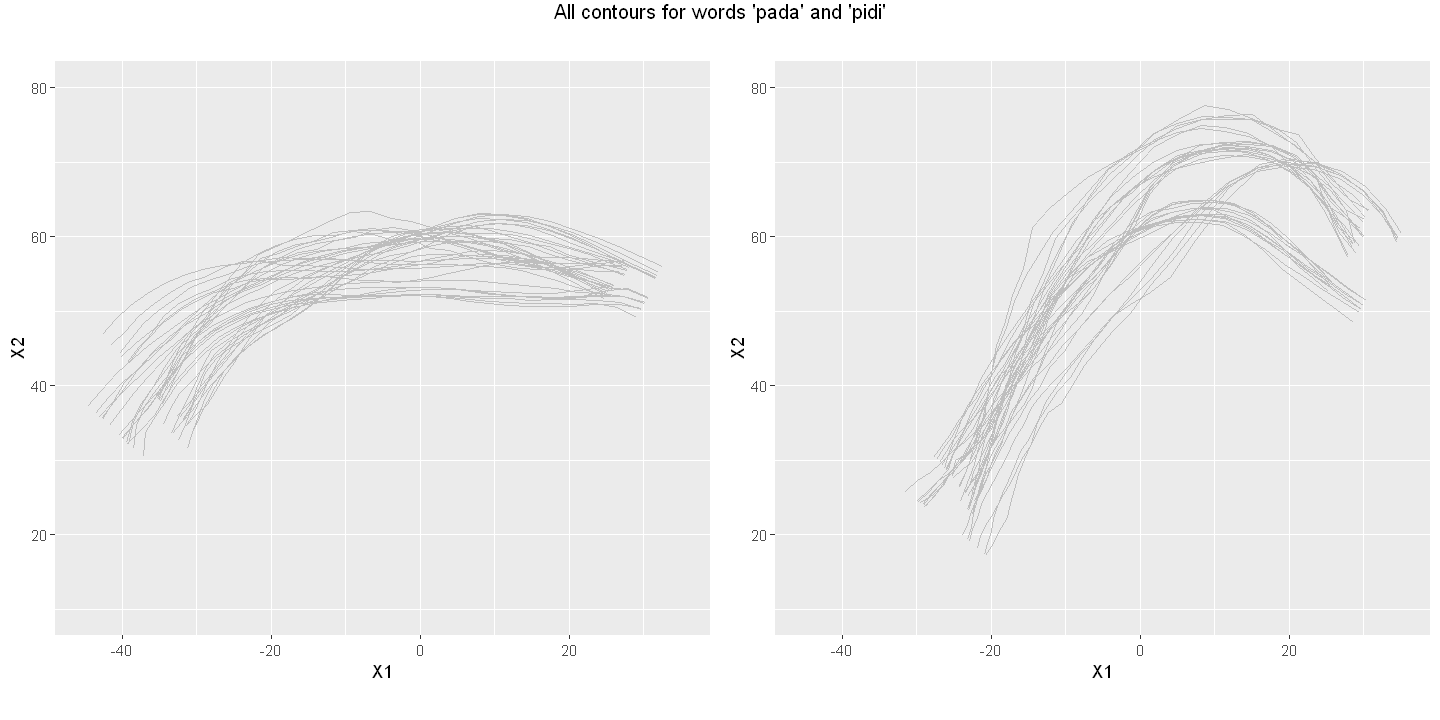

In [5]:
p1 <- ggplot(bind_rows(pada, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed(xlim=c(-45,35), ylim=c(10,80))

p2 <- ggplot(bind_rows(pidi, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed(xlim=c(-45,35), ylim=c(10,80))

options(repr.plot.width=12, repr.plot.height=6)
grid.arrange(p1, p2, nrow=1, top="All contours for words 'pada' and 'pidi'")

In [6]:
knots <- seq(0, 1, length = 30)
pada.mean <- compute_elastic_proc2d_mean(pada, knots = knots, type = "smooth", penalty = 2)
pidi.mean <- compute_elastic_proc2d_mean(pidi, knots = knots, type = "smooth", penalty = 2)

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

In [7]:
rot.pada <- mean(sapply(pada.mean$data_curves, function(curve){
    attr(curve, "rotation")
}))
rot.pidi <- mean(sapply(pidi.mean$data_curves, function(curve){
    attr(curve, "rotation")
}))

In [8]:
pfits.pada <- lapply(pada.mean$data_curves, function(curve){
    pfit <- get_procrustes_fit(curve)
    theta <- - rot.pada
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
theta <- - rot.pada
mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
mean.pada.rot <- as.data.frame(as.matrix(get_evals(pada.mean)) %*% mat)
mean.pada.rot[,1] <- mean.pada.rot[,1] - mean.pada.rot[nrow(mean.pidi.rot),1]
mean.pada.rot[,2] <- mean.pada.rot[,2] - mean.pada.rot[nrow(mean.pidi.rot),2]
colnames(mean.pada.rot) <- c("X1", "X2")

pfits.pidi <- lapply(pidi.mean$data_curves, function(curve){
    pfit <- get_procrustes_fit(curve)
    theta <- - rot.pidi
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
theta <- - rot.pidi
mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
mean.pidi.rot <- as.data.frame(as.matrix(get_evals(pidi.mean)) %*% mat)
mean.pidi.rot[,1] <- mean.pidi.rot[,1] - mean.pidi.rot[nrow(mean.pidi.rot),1]
mean.pidi.rot[,2] <- mean.pidi.rot[,2] - mean.pidi.rot[nrow(mean.pidi.rot),2]
colnames(mean.pidi.rot) <- c("X1", "X2")

ERROR: Error in nrow(mean.pidi.rot): object 'mean.pidi.rot' not found


In [ ]:
p1 <- ggplot(bind_rows(pfits.pada, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey", alpha=0.7) +
    geom_path(data=mean.pada.rot, aes(x=X1, y=X2), size=1, color="red") +
    coord_fixed(xlim=c(0,1),ylim=c(0,0.7))

p2 <- ggplot(bind_rows(pfits.pidi, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey", alpha=0.7) +
    geom_path(data=mean.pidi.rot, aes(x=X1, y=X2), size=1, color="red") +
    coord_fixed(xlim=c(0,1),ylim=c(0,0.7))

options(repr.plot.width=12, repr.plot.height=6)
grid.arrange(p1, p2, nrow=1, top="Procrustes fits and procrustes means for words 'pada' and 'pidi'")

#### Schätzung von $d(t)$ via stepwise means

In [41]:
pada <- pouplier %>%
    filter(WORD == "pada") %>%
    select(VPN, REP, X1, X2) %>%
    arrange(VPN, REP) %>%
    group_by(VPN) %>%
    group_split(.keep = FALSE)

pidi <- pouplier %>%
    filter(WORD == "pidi") %>%
    select(VPN, REP, X1, X2) %>%
    arrange(VPN, REP) %>%
    group_by(VPN) %>%
    group_split(.keep = FALSE)

pada <- lapply(pada, function(rep) {
    rep %>% 
        group_by(REP) %>%
        group_split(.keep = FALSE)
})

pidi <- lapply(pidi, function(rep) {
    rep %>% 
        group_by(REP) %>%
        group_split(.keep = FALSE)
})

[1] "Number of VPN :"
[1] "\t pada : 6"
[1] "\t pidi : 6"


In [40]:
knots <- seq(0, 1, length = 30)
pada.vpn.means <- lapply(pada, function(vpn){
    compute_elastic_proc2d_mean(vpn, knots = knots, type = "smooth", penalty = 2)
})
pidi.vpn.means <- lapply(pidi, function(vpn){
    compute_elastic_proc2d_mean(vpn, knots = knots, type = "smooth", penalty = 2)
})

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis

In [75]:
pada.rots <- lapply(pada.vpn.means, function(vpn.mean) {
    mean(sapply(vpn.mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
})
pidi.rots <- lapply(pidi.vpn.means, function(vpn.mean) {
    mean(sapply(vpn.mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
})

In [76]:
pada.vpn.curves <- lapply(seq_along(pada.vpn.means), function(i){
    theta <- - pada.rots[[i]]
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(get_evals(pada.vpn.means[[i]])) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
pidi.vpn.curves <- lapply(seq_along(pidi.vpn.means), function(i){
    theta <- - pidi.rots[[i]]
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(get_evals(pidi.vpn.means[[i]])) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})

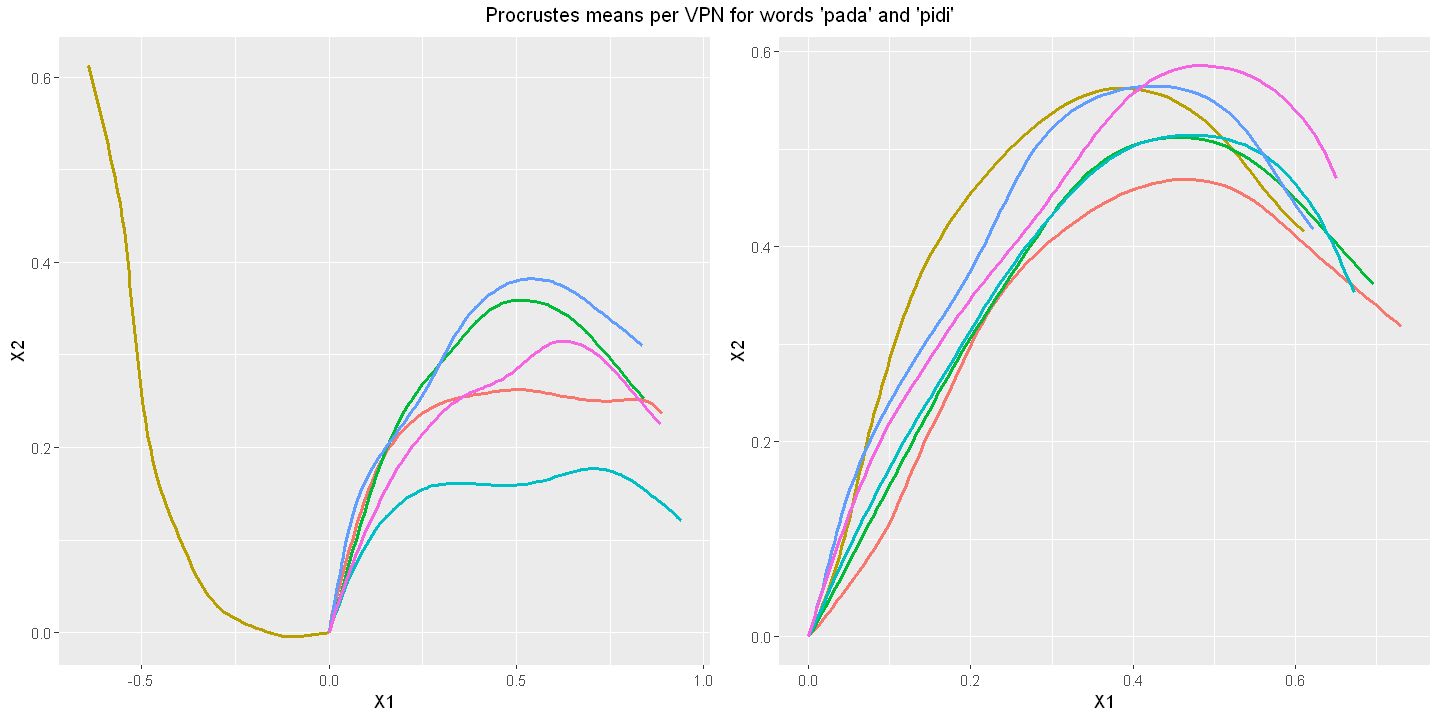

In [77]:
p1 <- ggplot(bind_rows(pada.vpn.curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(col=id), size=1, show.legend=FALSE)# +
    #coord_fixed(xlim=c(0,0.9),ylim=c(0,0.6))

p2 <- ggplot(bind_rows(pidi.vpn.curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(col=id), size=1, show.legend=FALSE) #+
    #coord_fixed(xlim=c(0,0.9),ylim=c(0,0.6))

options(repr.plot.width=12, repr.plot.height=6)
grid.arrange(p1, p2, nrow=1, top="Procrustes means per VPN for words 'pada' and 'pidi'")

In [88]:
d.curves <- lapply(seq_along(pada.vpn.curves), function(i){
    pada.vpn.curves[[i]] - pidi.vpn.curves[[i]]
})
d.curves <- d.curves[c(1,3,4,5,6)]

In [89]:
d.mean <- compute_elastic_proc2d_mean(d.curves, knots = knots, type = "smooth", penalty = 2)

In [93]:
d.rot <- mean(sapply(d.mean$data_curves, function(curve){
        attr(curve, "rotation")
    }))
d.pfits <- lapply(d.mean$data_curves, function(curve){
    pfit <- get_procrustes_fit(curve)
    theta <- - d.rot
    mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
    curve <- as.data.frame(as.matrix(pfit[,c(3,4)]) %*% mat)
    curve[,1] <- curve[,1] - curve[nrow(curve),1]
    curve[,2] <- curve[,2] - curve[nrow(curve),2]
    colnames(curve) <- c("X1", "X2")
    curve
})
theta <- - d.rot
mat <- matrix(c(cos(theta), - sin(theta), sin(theta), cos(theta)), nrow = 2, ncol = 2)
curve <- as.data.frame(as.matrix(get_evals(d.mean)) %*% mat)
curve[,1] <- curve[,1] - curve[nrow(curve),1]
curve[,2] <- curve[,2] - curve[nrow(curve),2]
colnames(curve) <- c("X1", "X2")
d.mean.rot <- curve

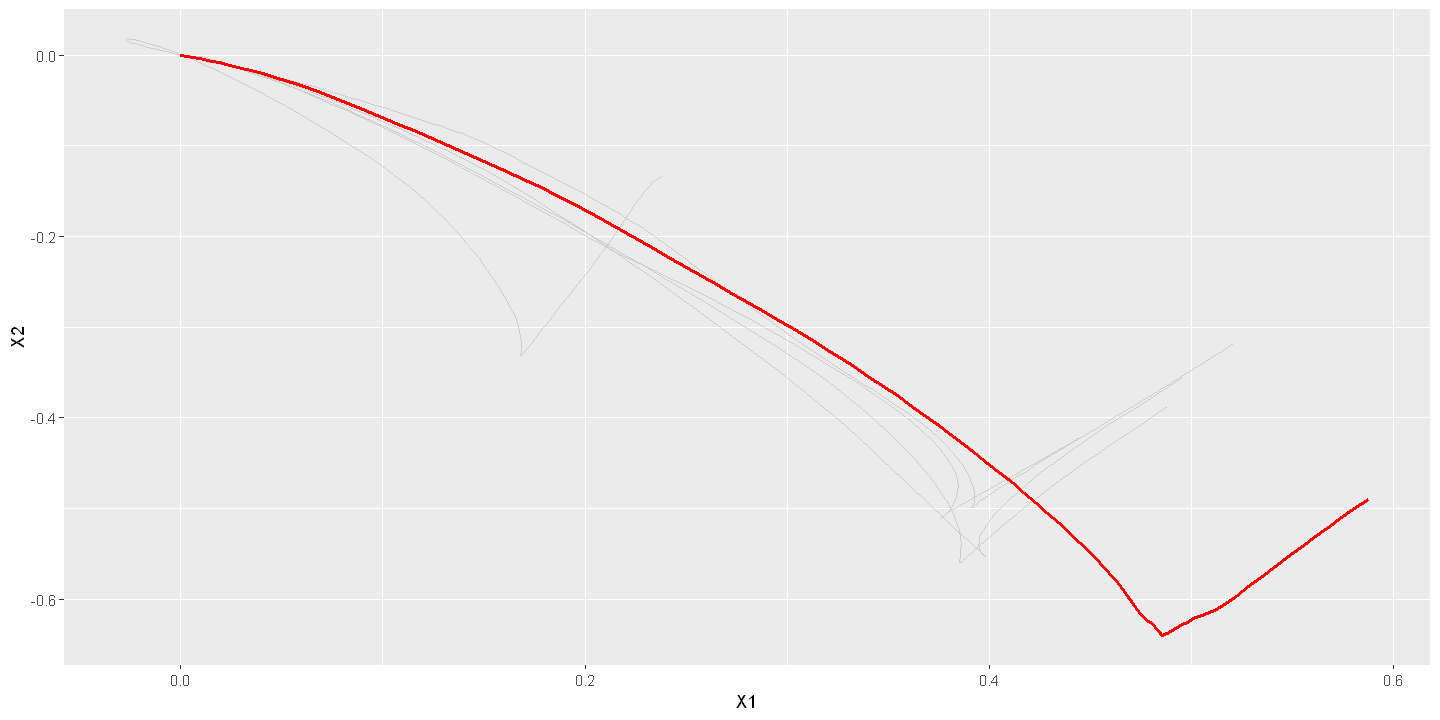

In [96]:
ggplot(bind_rows(d.pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey", alpha=0.7) +
    geom_path(data=d.mean.rot, aes(x=X1, y=X2), size=1, color="red")